In [1]:
from dataset import PriceData
dataset = PriceData(30)
len(dataset)

/Users/jekabsgritans/miniconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1097/1097 [00:12<00:00, 89.92it/s]


28981

In [16]:
from utils import gradient_penalty
from tqdm import tqdm
def train_gan(model, latent_size, g_optim, c_optim, critic_iterations, lambda_gp, epochs, train_loader, device):
    for epoch in range(1,epochs+1):
        c_losses = []
        g_losses = []
        for x_real in tqdm(train_loader):
            batch_size = x_real.size(0)
            x_real = x_real.to(device)
            
            # Train the critic
            for _ in range(critic_iterations):
                noise = torch.randn(batch_size, latent_size).to(device)
                x_fake = model.forward_generator(noise)
                critic_real = model.forward_critic(x_real)
                critic_fake = model.forward_critic(x_fake)
                gp = gradient_penalty(model.critic, x_real, x_fake, device=device)
                loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake)) + lambda_gp*gp
                c_optim.zero_grad()
                loss_critic.backward(retain_graph=True)
                c_optim.step()

            # Train the generator
            output = model.forward_critic(x_fake)
            loss_gen = -torch.mean(output)
            g_optim.zero_grad()
            loss_gen.backward()
            g_optim.step()

            # Save losses
            loss_critic = loss_critic.item()
            loss_gen = loss_gen.item()
            c_losses.append(loss_critic)
            g_losses.append(loss_gen)
    return c_losses, g_losses


In [17]:
from model import GAN
from torch.utils.data import DataLoader
import torch.optim as optim
import torch

LATENT_SIZE = 100
OUT_SIZE = 30
LR = 1e-4
NUM_EPOCHS = 1
BATCH_SIZE = 64
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

device = torch.device("cpu")
gan = GAN(out_size=OUT_SIZE, latent_size=LATENT_SIZE, device=device)

g_optim = optim.Adam(gan.generator.parameters(), lr=LR, betas=(0.0,0.9))
c_optim = optim.Adam(gan.critic.parameters(), lr=LR, betas=(0.0,0.9))

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE)
c_losses, g_losses = train_gan(
    model=gan,
    latent_size=LATENT_SIZE,
    g_optim=g_optim,
    c_optim=c_optim,
    critic_iterations=CRITIC_ITERATIONS,
    lambda_gp = LAMBDA_GP,
    epochs=NUM_EPOCHS,   
    train_loader = train_loader,
    device=device
)

100%|██████████| 453/453 [00:25<00:00, 17.69it/s]


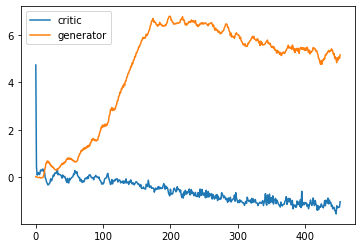

In [18]:
import matplotlib.pyplot as plt
plt.plot(c_losses, label='critic')
plt.plot(g_losses, label='generator')
plt.legend()
plt.show()

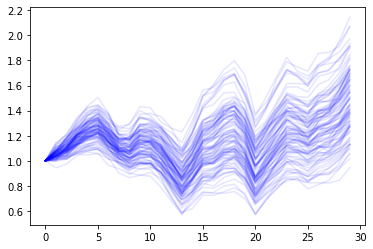

In [88]:
noise = torch.randn(100, LATENT_SIZE).to(device)
x_fake = gan.forward_generator(noise)
for data in x_fake:
    cum = np.cumsum(data.cpu().detach().numpy(), axis=0)
    cum+=1-cum[0]
    plt.plot(cum,'b', alpha=0.1)
plt.show()